### 1. 필요모듈 가져오기

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import koreanize_matplotlib

In [3]:
from sklearn.model_selection import train_test_split

# 랜덤 시드 결정
seed_num = 11
np.random.seed(seed_num)
torch.manual_seed(seed_num) 

# 폴더에서 데이터 로드 
dataset = ImageFolder(root="../data/resnet_data")
dataset_indices = list(range(len(dataset)))

In [4]:
targets = dataset.targets

In [5]:
# 80 : 20 나누기
train_indices, val_test_indices = train_test_split(dataset_indices, test_size=0.2, stratify=targets, random_state=seed_num)

In [6]:
val_test_target = [targets[i] for i in val_test_indices]

In [7]:
# 20 -> 10: 10으로 분할하기
val_indices, test_indices = train_test_split(val_test_indices, test_size=0.5, stratify=val_test_target, random_state=seed_num)

In [8]:
# train_indices, val_indices, test_indices
# 최종 데이터셋 생성
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

In [9]:
len(dataset), len(train_dataset), len(val_dataset), len(test_dataset)

(418, 334, 42, 42)

In [10]:
class_idx = dataset.class_to_idx
class_idx

{'마동석': 0, '박보영': 1, '차은우': 2, '카리나': 3}

In [11]:
class_names = {}
for key, val in class_idx.items():
    class_names[val] = key

In [12]:
class_names

{0: '마동석', 1: '박보영', 2: '차은우', 3: '카리나'}

In [13]:
for i in test_dataset:
    print(i)

(<PIL.Image.Image image mode=RGB size=860x1110 at 0x20BA4706530>, 2)
(<PIL.Image.Image image mode=RGB size=1400x2205 at 0x20BD8AB93C0>, 1)
(<PIL.Image.Image image mode=RGB size=1242x1610 at 0x20BA4706DA0>, 2)
(<PIL.Image.Image image mode=RGB size=700x1202 at 0x20BD8AB9360>, 2)
(<PIL.Image.Image image mode=RGB size=1600x1091 at 0x20BA4706D70>, 0)
(<PIL.Image.Image image mode=RGB size=760x1142 at 0x20BD8AB9390>, 3)
(<PIL.Image.Image image mode=RGB size=1200x1500 at 0x20BA4706530>, 3)
(<PIL.Image.Image image mode=RGB size=473x521 at 0x20BD8AB93C0>, 0)
(<PIL.Image.Image image mode=RGB size=1242x2000 at 0x20BA4706DA0>, 1)
(<PIL.Image.Image image mode=RGB size=800x1199 at 0x20BD8AB9360>, 0)
(<PIL.Image.Image image mode=RGB size=1000x1000 at 0x20BA4706D70>, 2)
(<PIL.Image.Image image mode=RGB size=960x1440 at 0x20BD8AB9390>, 0)
(<PIL.Image.Image image mode=RGB size=640x960 at 0x20BA4706530>, 2)
(<PIL.Image.Image image mode=RGB size=650x650 at 0x20BD8AB9360>, 2)
(<PIL.Image.Image image mode=RG

ValueError: num must be an integer with 1 <= num <= 16, not 17

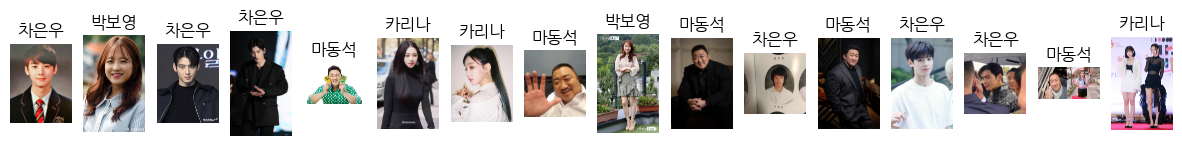

In [14]:
# 시각화 해보기
plt.figure(figsize=(15, 8))
for idx, item in enumerate(test_dataset, start=1):
    plt.subplot(1, 16, idx)
    image = item[0]
    class_name = class_names[item[1]]
    plt.title(class_name)
    plt.axis("off")
    plt.imshow(image)
plt.show()

### 3. 이미지 증강 및 전처리 설정 - transforms

In [ ]:
# 평균과 표준편차 계산
def get_mean_std(loader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0

    for data, _ in loader:
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
        num_batches += 1

    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean**2)**0.5
    return mean, std

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
# transform 설정
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = test_transform
test_dataset.dataset.transform = test_transform

# 데이터 로더 설정
batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

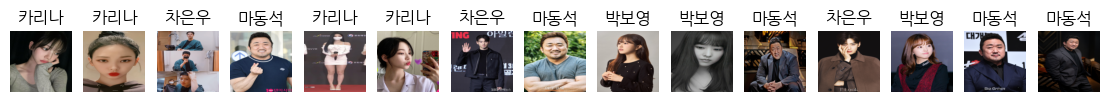

In [ ]:
### train dataset 에 transform 적용 확인해보기
plt.figure(figsize=(15, 8))

for idx, item in enumerate(train_dataset, start=1):
    if idx == 16:
        break
    plt.subplot(1, 16, idx)
    
    mean=np.array([0.485, 0.456, 0.406])
    std=np.array([0.229, 0.224, 0.225])

    image = item[0]
    image = image.cpu().detach().numpy().transpose((1,2,0)) # w, h, c
    image = std * image + mean
    image = np.clip(image, 0, 1)
    
    class_name = class_names[item[1]]
    plt.title(class_name)
    plt.axis("off")
    plt.imshow(image)
plt.show()

### 4. 모델 설정

In [ ]:
model_ResNet = models.resnet50(weights=None, num_classes=4)

### 5. 손실함수와 옵티마이저 설정

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_ResNet.parameters(), lr=0.001)

### 6. 학습하기

In [ ]:
import torchmetrics
from tqdm.notebook import tqdm

def train_and_validate(model, train_loader, val_loader, optimizer, criterion, epochs, device):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    max_val_acc = 0

    model = model.to(device)

    # 옵티마이저 다시 설정
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        # 모델을 학습 모드로 설정
        model.train()
        running_loss = 0.0
        train_accuracy_metric = torchmetrics.Accuracy(task='multiclass', num_classes=4, average='macro').to(device)

        # 학습 데이터에 대한 반복
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - 학습중"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()  # 그라디언트 초기화
            outputs = model(inputs)  # 모델을 통한 예측
            loss = criterion(outputs, labels)  # 손실 계산
            loss.backward()  # 역전파
            optimizer.step()  # 최적화 단계

            running_loss += loss.item()
            # 학습 정확도 계산
            train_accuracy_metric.update(outputs, labels)

        # 에포크의 평균 학습 손실 계산
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)

        train_accuracy = train_accuracy_metric.compute().item()
        train_accuracies.append(train_accuracy)

        print(f'Epoch [{epoch + 1}/{epochs}] - Training loss: {epoch_loss:.3f} / Train acc : {train_accuracy:2%}')

        # 검증 과정
        model.eval()  # 모델을 평가 모드로 설정
        running_val_loss = 0.0
        val_accuracy_metric = torchmetrics.Accuracy(task='multiclass', num_classes=4, average='macro').to(device)

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} - 평가중"):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()
                val_accuracy_metric.update(outputs, labels)


        # 에포크의 평균 검증 손실 계산
        epoch_val_loss = running_val_loss / len(val_loader)
        val_losses.append(epoch_val_loss)
        val_accuracy = val_accuracy_metric.compute().item()
        
        if val_accuracy > max_val_acc :
            torch.save(model.state_dict(), "best_Resnet34.pth")
            max_val_acc = val_accuracy
            print(f"{epoch}_{val_accuracy} 의 정확도인 베스트 모델 저장")
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch + 1}/{epochs}] - Validation loss: {epoch_val_loss:.3f} / Val acc : {val_accuracy:2%}')

    return train_losses, val_losses, train_accuracies, val_accuracies

In [ ]:
device = torch.device("cuda")
history = train_and_validate(model_ResNet, train_loader, val_loader, optimizer, criterion, epochs=100, device=device)

Epoch 1/100 - 학습중:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [1/100] - Training loss: 2.209 / Train acc : 32.031250%


Epoch 1/100 - 평가중:   0%|          | 0/4 [00:00<?, ?it/s]

0_0.3125 의 정확도인 베스트 모델 저장
Epoch [1/100] - Validation loss: 1.876 / Val acc : 31.250000%


Epoch 2/100 - 학습중:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [2/100] - Training loss: 1.760 / Train acc : 29.687500%


Epoch 2/100 - 평가중:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [2/100] - Validation loss: 63.146 / Val acc : 25.000000%


Epoch 3/100 - 학습중:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [3/100] - Training loss: 1.711 / Train acc : 23.437500%


Epoch 3/100 - 평가중:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [3/100] - Validation loss: 1.593 / Val acc : 31.250000%


Epoch 4/100 - 학습중:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [4/100] - Training loss: 1.627 / Train acc : 32.812500%


Epoch 4/100 - 평가중:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [4/100] - Validation loss: 1.425 / Val acc : 31.250000%


Epoch 5/100 - 학습중:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [5/100] - Training loss: 1.418 / Train acc : 26.562500%


Epoch 5/100 - 평가중:   0%|          | 0/4 [00:00<?, ?it/s]

4_0.4375 의 정확도인 베스트 모델 저장
Epoch [5/100] - Validation loss: 1.868 / Val acc : 43.750000%


Epoch 6/100 - 학습중:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [6/100] - Training loss: 1.504 / Train acc : 35.937500%


Epoch 6/100 - 평가중:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [6/100] - Validation loss: 3.516 / Val acc : 31.250000%


Epoch 7/100 - 학습중:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [7/100] - Training loss: 1.424 / Train acc : 32.812500%


Epoch 7/100 - 평가중:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [7/100] - Validation loss: 2.394 / Val acc : 31.250000%


Epoch 8/100 - 학습중:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [8/100] - Training loss: 1.497 / Train acc : 29.687500%


Epoch 8/100 - 평가중:   0%|          | 0/4 [00:00<?, ?it/s]

7_0.5625 의 정확도인 베스트 모델 저장
Epoch [8/100] - Validation loss: 1.259 / Val acc : 56.250000%


Epoch 9/100 - 학습중:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [9/100] - Training loss: 1.349 / Train acc : 41.406250%


Epoch 9/100 - 평가중:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [9/100] - Validation loss: 1.761 / Val acc : 18.750000%


Epoch 10/100 - 학습중:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [10/100] - Training loss: 1.432 / Train acc : 35.156250%


Epoch 10/100 - 평가중:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [10/100] - Validation loss: 2.587 / Val acc : 37.500000%


Epoch 11/100 - 학습중:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [11/100] - Training loss: 1.503 / Train acc : 26.562500%


Epoch 11/100 - 평가중:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [11/100] - Validation loss: 1.295 / Val acc : 31.250000%


Epoch 12/100 - 학습중:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [12/100] - Training loss: 1.419 / Train acc : 29.687500%


Epoch 12/100 - 평가중:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [12/100] - Validation loss: 1.290 / Val acc : 31.250000%


Epoch 13/100 - 학습중:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [13/100] - Training loss: 1.275 / Train acc : 40.625000%


Epoch 13/100 - 평가중:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [13/100] - Validation loss: 1.831 / Val acc : 43.750000%


Epoch 14/100 - 학습중:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [14/100] - Training loss: 1.358 / Train acc : 41.406250%


Epoch 14/100 - 평가중:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [14/100] - Validation loss: 1.535 / Val acc : 56.250000%


Epoch 15/100 - 학습중:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [15/100] - Training loss: 1.295 / Train acc : 36.718750%


Epoch 15/100 - 평가중:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [15/100] - Validation loss: 1.618 / Val acc : 50.000000%


Epoch 16/100 - 학습중:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [16/100] - Training loss: 1.255 / Train acc : 45.312500%


Epoch 16/100 - 평가중:   0%|          | 0/4 [00:00<?, ?it/s]

15_0.625 의 정확도인 베스트 모델 저장
Epoch [16/100] - Validation loss: 1.573 / Val acc : 62.500000%


Epoch 17/100 - 학습중:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [17/100] - Training loss: 1.319 / Train acc : 40.625000%


Epoch 17/100 - 평가중:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [17/100] - Validation loss: 2.063 / Val acc : 37.500000%


Epoch 18/100 - 학습중:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [18/100] - Training loss: 1.242 / Train acc : 45.312500%


Epoch 18/100 - 평가중:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [18/100] - Validation loss: 4.573 / Val acc : 50.000000%


Epoch 19/100 - 학습중:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [19/100] - Training loss: 1.172 / Train acc : 45.312500%


Epoch 19/100 - 평가중:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [19/100] - Validation loss: 1.648 / Val acc : 43.750000%


Epoch 20/100 - 학습중:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [20/100] - Training loss: 1.252 / Train acc : 45.312500%


Epoch 20/100 - 평가중:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [20/100] - Validation loss: 2.860 / Val acc : 31.250000%


Epoch 21/100 - 학습중:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [21/100] - Training loss: 1.128 / Train acc : 53.906250%


Epoch 21/100 - 평가중:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [21/100] - Validation loss: 1.237 / Val acc : 43.750000%


Epoch 22/100 - 학습중:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [22/100] - Training loss: 1.167 / Train acc : 52.343750%


Epoch 22/100 - 평가중:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [22/100] - Validation loss: 1.626 / Val acc : 43.750000%


Epoch 23/100 - 학습중:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [23/100] - Training loss: 1.172 / Train acc : 50.781250%


Epoch 23/100 - 평가중:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [23/100] - Validation loss: 1.263 / Val acc : 50.000000%


Epoch 24/100 - 학습중:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [24/100] - Training loss: 1.040 / Train acc : 53.125000%


Epoch 24/100 - 평가중:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [24/100] - Validation loss: 2.071 / Val acc : 56.250000%


Epoch 25/100 - 학습중:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [25/100] - Training loss: 1.200 / Train acc : 52.343750%


Epoch 25/100 - 평가중:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [25/100] - Validation loss: 1.228 / Val acc : 43.750000%


Epoch 26/100 - 학습중:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [26/100] - Training loss: 1.089 / Train acc : 57.812500%


Epoch 26/100 - 평가중:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [26/100] - Validation loss: 1.508 / Val acc : 56.250000%


Epoch 27/100 - 학습중:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [27/100] - Training loss: 1.080 / Train acc : 59.375000%


Epoch 27/100 - 평가중:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [27/100] - Validation loss: 1.382 / Val acc : 43.750000%


Epoch 28/100 - 학습중:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [28/100] - Training loss: 0.996 / Train acc : 62.500000%


Epoch 28/100 - 평가중:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [28/100] - Validation loss: 1.317 / Val acc : 43.750000%


Epoch 29/100 - 학습중:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [29/100] - Training loss: 1.090 / Train acc : 47.656250%


Epoch 29/100 - 평가중:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [29/100] - Validation loss: 1.691 / Val acc : 56.250000%


Epoch 30/100 - 학습중:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [30/100] - Training loss: 1.120 / Train acc : 57.031250%


Epoch 30/100 - 평가중:   0%|          | 0/4 [00:00<?, ?it/s]

29_0.6875 의 정확도인 베스트 모델 저장
Epoch [30/100] - Validation loss: 1.048 / Val acc : 68.750000%


Epoch 31/100 - 학습중:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [31/100] - Training loss: 1.091 / Train acc : 57.031250%


Epoch 31/100 - 평가중:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [31/100] - Validation loss: 1.202 / Val acc : 37.500000%


Epoch 32/100 - 학습중:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [32/100] - Training loss: 0.885 / Train acc : 61.718750%


Epoch 32/100 - 평가중:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [32/100] - Validation loss: 1.856 / Val acc : 37.500000%


Epoch 33/100 - 학습중:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [33/100] - Training loss: 1.068 / Train acc : 65.625000%


Epoch 33/100 - 평가중:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [33/100] - Validation loss: 2.166 / Val acc : 50.000000%


Epoch 34/100 - 학습중:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [34/100] - Training loss: 1.063 / Train acc : 54.687500%


Epoch 34/100 - 평가중:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [34/100] - Validation loss: 1.505 / Val acc : 43.750000%


Epoch 35/100 - 학습중:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [35/100] - Training loss: 1.039 / Train acc : 58.593750%


Epoch 35/100 - 평가중:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [35/100] - Validation loss: 1.698 / Val acc : 37.500000%


Epoch 36/100 - 학습중:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [36/100] - Training loss: 0.768 / Train acc : 71.875000%


Epoch 36/100 - 평가중:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [36/100] - Validation loss: 4.356 / Val acc : 50.000000%


Epoch 37/100 - 학습중:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [37/100] - Training loss: 1.067 / Train acc : 53.125000%


Epoch 37/100 - 평가중:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [37/100] - Validation loss: 2.107 / Val acc : 37.500000%


Epoch 38/100 - 학습중:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [38/100] - Training loss: 0.797 / Train acc : 71.093750%


Epoch 38/100 - 평가중:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [38/100] - Validation loss: 1.723 / Val acc : 50.000000%


Epoch 39/100 - 학습중:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [39/100] - Training loss: 0.763 / Train acc : 70.312500%


Epoch 39/100 - 평가중:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [39/100] - Validation loss: 2.571 / Val acc : 18.750000%


Epoch 40/100 - 학습중:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [40/100] - Training loss: 0.882 / Train acc : 67.187500%


Epoch 40/100 - 평가중:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [40/100] - Validation loss: 1.640 / Val acc : 43.750000%


Epoch 41/100 - 학습중:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [41/100] - Training loss: 0.657 / Train acc : 75.000000%


Epoch 41/100 - 평가중:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [41/100] - Validation loss: 1.556 / Val acc : 62.500000%


Epoch 42/100 - 학습중:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [42/100] - Training loss: 0.580 / Train acc : 79.687500%


Epoch 42/100 - 평가중:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [42/100] - Validation loss: 2.167 / Val acc : 37.500000%


Epoch 43/100 - 학습중:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [43/100] - Training loss: 0.715 / Train acc : 72.656250%


Epoch 43/100 - 평가중:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [43/100] - Validation loss: 2.062 / Val acc : 31.250000%


Epoch 44/100 - 학습중:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [44/100] - Training loss: 0.774 / Train acc : 73.437500%


Epoch 44/100 - 평가중:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [44/100] - Validation loss: 4.079 / Val acc : 31.250000%


Epoch 45/100 - 학습중:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [45/100] - Training loss: 1.118 / Train acc : 54.687500%


Epoch 45/100 - 평가중:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [45/100] - Validation loss: 2.986 / Val acc : 37.500000%


Epoch 46/100 - 학습중:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [46/100] - Training loss: 0.686 / Train acc : 75.000000%


Epoch 46/100 - 평가중:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [46/100] - Validation loss: 1.450 / Val acc : 56.250000%


Epoch 47/100 - 학습중:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [47/100] - Training loss: 0.512 / Train acc : 81.250000%


Epoch 47/100 - 평가중:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [47/100] - Validation loss: 1.817 / Val acc : 43.750000%


Epoch 48/100 - 학습중:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [48/100] - Training loss: 0.603 / Train acc : 76.562500%


Epoch 48/100 - 평가중:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [48/100] - Validation loss: 3.156 / Val acc : 43.750000%


Epoch 49/100 - 학습중:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [49/100] - Training loss: 0.702 / Train acc : 71.875000%


Epoch 49/100 - 평가중:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [49/100] - Validation loss: 1.928 / Val acc : 43.750000%


Epoch 50/100 - 학습중:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [50/100] - Training loss: 0.606 / Train acc : 75.781250%


Epoch 50/100 - 평가중:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [50/100] - Validation loss: 2.273 / Val acc : 43.750000%


Epoch 51/100 - 학습중:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [51/100] - Training loss: 0.457 / Train acc : 85.156250%


Epoch 51/100 - 평가중:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [51/100] - Validation loss: 2.514 / Val acc : 50.000000%


Epoch 52/100 - 학습중:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [52/100] - Training loss: 0.457 / Train acc : 85.156250%


Epoch 52/100 - 평가중:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [52/100] - Validation loss: 2.587 / Val acc : 37.500000%


Epoch 53/100 - 학습중:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [53/100] - Training loss: 0.604 / Train acc : 75.781250%


Epoch 53/100 - 평가중:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [53/100] - Validation loss: 1.877 / Val acc : 62.500000%


Epoch 54/100 - 학습중:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [54/100] - Training loss: 0.516 / Train acc : 76.562500%


Epoch 54/100 - 평가중:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [54/100] - Validation loss: 2.074 / Val acc : 31.250000%


Epoch 55/100 - 학습중:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [55/100] - Training loss: 0.462 / Train acc : 82.812500%


Epoch 55/100 - 평가중:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [55/100] - Validation loss: 2.050 / Val acc : 43.750000%


Epoch 56/100 - 학습중:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [56/100] - Training loss: 0.309 / Train acc : 88.281250%


Epoch 56/100 - 평가중:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [56/100] - Validation loss: 2.356 / Val acc : 31.250000%


Epoch 57/100 - 학습중:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [57/100] - Training loss: 0.359 / Train acc : 87.500000%


Epoch 57/100 - 평가중:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [57/100] - Validation loss: 2.618 / Val acc : 18.750000%


Epoch 58/100 - 학습중:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [58/100] - Training loss: 0.421 / Train acc : 86.718750%


Epoch 58/100 - 평가중:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [58/100] - Validation loss: 2.204 / Val acc : 12.500000%


Epoch 59/100 - 학습중:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [59/100] - Training loss: 0.229 / Train acc : 93.750000%


Epoch 59/100 - 평가중:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [59/100] - Validation loss: 2.130 / Val acc : 37.500000%


Epoch 60/100 - 학습중:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [60/100] - Training loss: 0.127 / Train acc : 96.093750%


Epoch 60/100 - 평가중:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [60/100] - Validation loss: 2.359 / Val acc : 43.750000%


Epoch 61/100 - 학습중:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [61/100] - Training loss: 0.158 / Train acc : 94.531250%


Epoch 61/100 - 평가중:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [61/100] - Validation loss: 3.362 / Val acc : 25.000000%


Epoch 62/100 - 학습중:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [62/100] - Training loss: 0.226 / Train acc : 92.968750%


Epoch 62/100 - 평가중:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [62/100] - Validation loss: 2.266 / Val acc : 37.500000%


Epoch 63/100 - 학습중:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [63/100] - Training loss: 0.075 / Train acc : 98.437500%


Epoch 63/100 - 평가중:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [63/100] - Validation loss: 3.618 / Val acc : 43.750000%


Epoch 64/100 - 학습중:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [64/100] - Training loss: 0.278 / Train acc : 89.843750%


Epoch 64/100 - 평가중:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [64/100] - Validation loss: 4.966 / Val acc : 37.500000%


Epoch 65/100 - 학습중:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [65/100] - Training loss: 0.258 / Train acc : 92.968750%


Epoch 65/100 - 평가중:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [65/100] - Validation loss: 2.118 / Val acc : 31.250000%


Epoch 66/100 - 학습중:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [66/100] - Training loss: 0.102 / Train acc : 96.093750%


Epoch 66/100 - 평가중:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [66/100] - Validation loss: 3.085 / Val acc : 31.250000%


Epoch 67/100 - 학습중:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [67/100] - Training loss: 0.328 / Train acc : 89.062500%


Epoch 67/100 - 평가중:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [67/100] - Validation loss: 3.249 / Val acc : 37.500000%


Epoch 68/100 - 학습중:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [68/100] - Training loss: 0.541 / Train acc : 82.031250%


Epoch 68/100 - 평가중:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [68/100] - Validation loss: 2.979 / Val acc : 37.500000%


Epoch 69/100 - 학습중:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [69/100] - Training loss: 0.446 / Train acc : 84.375000%


Epoch 69/100 - 평가중:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [69/100] - Validation loss: 2.954 / Val acc : 25.000000%


Epoch 70/100 - 학습중:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [70/100] - Training loss: 0.255 / Train acc : 89.843750%


Epoch 70/100 - 평가중:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [70/100] - Validation loss: 3.022 / Val acc : 37.500000%


Epoch 71/100 - 학습중:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [71/100] - Training loss: 0.383 / Train acc : 85.937500%


Epoch 71/100 - 평가중:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [71/100] - Validation loss: 4.550 / Val acc : 31.250000%


Epoch 72/100 - 학습중:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [72/100] - Training loss: 0.229 / Train acc : 93.750000%


Epoch 72/100 - 평가중:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [72/100] - Validation loss: 3.429 / Val acc : 18.750000%


Epoch 73/100 - 학습중:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [73/100] - Training loss: 0.144 / Train acc : 96.093750%


Epoch 73/100 - 평가중:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [73/100] - Validation loss: 2.837 / Val acc : 25.000000%


Epoch 74/100 - 학습중:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [74/100] - Training loss: 0.142 / Train acc : 95.312500%


Epoch 74/100 - 평가중:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [74/100] - Validation loss: 2.618 / Val acc : 37.500000%


Epoch 75/100 - 학습중:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [75/100] - Training loss: 0.083 / Train acc : 97.656250%


Epoch 75/100 - 평가중:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [75/100] - Validation loss: 2.334 / Val acc : 37.500000%


Epoch 76/100 - 학습중:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [76/100] - Training loss: 0.032 / Train acc : 100.000000%


Epoch 76/100 - 평가중:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [76/100] - Validation loss: 2.649 / Val acc : 31.250000%


Epoch 77/100 - 학습중:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [77/100] - Training loss: 0.047 / Train acc : 98.437500%


Epoch 77/100 - 평가중:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [77/100] - Validation loss: 3.000 / Val acc : 25.000000%


Epoch 78/100 - 학습중:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [78/100] - Training loss: 0.048 / Train acc : 98.437500%


Epoch 78/100 - 평가중:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [78/100] - Validation loss: 3.848 / Val acc : 37.500000%


Epoch 79/100 - 학습중:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [79/100] - Training loss: 0.130 / Train acc : 96.875000%


Epoch 79/100 - 평가중:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [79/100] - Validation loss: 3.436 / Val acc : 25.000000%


Epoch 80/100 - 학습중:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [80/100] - Training loss: 0.174 / Train acc : 92.187500%


Epoch 80/100 - 평가중:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [80/100] - Validation loss: 4.405 / Val acc : 43.750000%


Epoch 81/100 - 학습중:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [81/100] - Training loss: 0.700 / Train acc : 80.468750%


Epoch 81/100 - 평가중:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [81/100] - Validation loss: 4.158 / Val acc : 31.250000%


Epoch 82/100 - 학습중:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [82/100] - Training loss: 0.767 / Train acc : 68.750000%


Epoch 82/100 - 평가중:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [82/100] - Validation loss: 3.429 / Val acc : 37.500000%


Epoch 83/100 - 학습중:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [83/100] - Training loss: 0.475 / Train acc : 85.156250%


Epoch 83/100 - 평가중:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [83/100] - Validation loss: 1.845 / Val acc : 37.500000%


Epoch 84/100 - 학습중:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [84/100] - Training loss: 0.132 / Train acc : 96.875000%


Epoch 84/100 - 평가중:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [84/100] - Validation loss: 1.988 / Val acc : 43.750000%


Epoch 85/100 - 학습중:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [85/100] - Training loss: 0.085 / Train acc : 97.656250%


Epoch 85/100 - 평가중:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [85/100] - Validation loss: 2.396 / Val acc : 43.750000%


Epoch 86/100 - 학습중:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [86/100] - Training loss: 0.057 / Train acc : 99.218750%


Epoch 86/100 - 평가중:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [86/100] - Validation loss: 2.697 / Val acc : 37.500000%


Epoch 87/100 - 학습중:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [87/100] - Training loss: 0.030 / Train acc : 100.000000%


Epoch 87/100 - 평가중:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [87/100] - Validation loss: 2.493 / Val acc : 31.250000%


Epoch 88/100 - 학습중:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [88/100] - Training loss: 0.023 / Train acc : 100.000000%


Epoch 88/100 - 평가중:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [88/100] - Validation loss: 2.580 / Val acc : 31.250000%


Epoch 89/100 - 학습중:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [89/100] - Training loss: 0.031 / Train acc : 98.437500%


Epoch 89/100 - 평가중:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [89/100] - Validation loss: 2.615 / Val acc : 50.000000%


Epoch 90/100 - 학습중:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [90/100] - Training loss: 0.144 / Train acc : 94.531250%


Epoch 90/100 - 평가중:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [90/100] - Validation loss: 2.768 / Val acc : 43.750000%


Epoch 91/100 - 학습중:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [91/100] - Training loss: 0.128 / Train acc : 96.093750%


Epoch 91/100 - 평가중:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [91/100] - Validation loss: 5.341 / Val acc : 31.250000%


Epoch 92/100 - 학습중:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [92/100] - Training loss: 0.155 / Train acc : 96.093750%


Epoch 92/100 - 평가중:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [92/100] - Validation loss: 3.500 / Val acc : 50.000000%


Epoch 93/100 - 학습중:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [93/100] - Training loss: 0.218 / Train acc : 92.968750%


Epoch 93/100 - 평가중:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [93/100] - Validation loss: 2.790 / Val acc : 37.500000%


Epoch 94/100 - 학습중:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [94/100] - Training loss: 0.109 / Train acc : 96.875000%


Epoch 94/100 - 평가중:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [94/100] - Validation loss: 2.975 / Val acc : 37.500000%


Epoch 95/100 - 학습중:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [95/100] - Training loss: 0.043 / Train acc : 98.437500%


Epoch 95/100 - 평가중:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [95/100] - Validation loss: 3.949 / Val acc : 25.000000%


Epoch 96/100 - 학습중:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [96/100] - Training loss: 0.063 / Train acc : 99.218750%


Epoch 96/100 - 평가중:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [96/100] - Validation loss: 4.426 / Val acc : 25.000000%


Epoch 97/100 - 학습중:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [97/100] - Training loss: 0.089 / Train acc : 96.875000%


Epoch 97/100 - 평가중:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [97/100] - Validation loss: 4.155 / Val acc : 18.750000%


Epoch 98/100 - 학습중:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [98/100] - Training loss: 0.206 / Train acc : 92.968750%


Epoch 98/100 - 평가중:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [98/100] - Validation loss: 3.259 / Val acc : 31.250000%


Epoch 99/100 - 학습중:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [99/100] - Training loss: 0.056 / Train acc : 96.875000%


Epoch 99/100 - 평가중:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [99/100] - Validation loss: 3.910 / Val acc : 31.250000%


Epoch 100/100 - 학습중:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [100/100] - Training loss: 0.054 / Train acc : 98.437500%


Epoch 100/100 - 평가중:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [100/100] - Validation loss: 4.390 / Val acc : 25.000000%


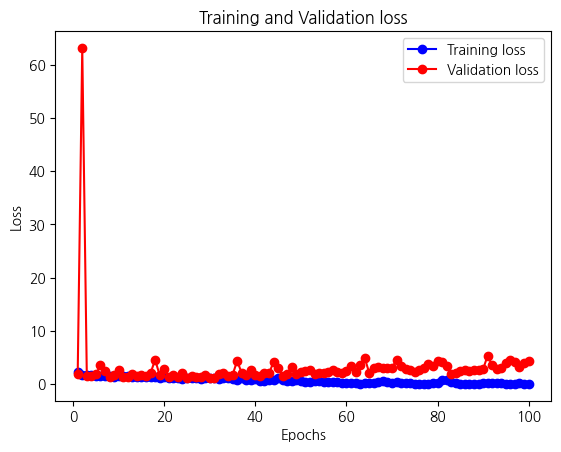

In [ ]:
import matplotlib.pyplot as plt

# train_and_validate 함수로부터 손실 기록 받기
train_losses, val_losses = history[:2]

# 에포크 번호를 기준으로 그래프를 그립니다.
epochs = range(1, len(train_losses) + 1)

# 학습 및 검증 손실 그래프 그리기
plt.plot(epochs, train_losses, 'bo-', label='Training loss')
plt.plot(epochs, val_losses, 'ro-', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
def evaluate(model, loader, device):
    model.eval()
    accuracy_metric = torchmetrics.Accuracy(task='multiclass', num_classes=4, average='macro').to(device)
    with torch.no_grad():
        for data in tqdm(loader, desc=f"최종평가중"):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            # 정확도 업데이트
            accuracy_metric.update(outputs, labels)
    accuracy = accuracy_metric.compute()  # 정확도 계산
    print(f'테스트 이미지 정확도 계산: {accuracy.item() * 100:.2f}%')
    return accuracy.item()

In [ ]:
evaluate(model_ResNet, train_loader, device)

최종평가중:   0%|          | 0/32 [00:00<?, ?it/s]

테스트 이미지 정확도 계산: 100.00%


1.0